# YOLO v3 Finetuning on AWS

This series of notebooks demonstrates how to finetune pretrained YOLO v3 (aka YOLO3) using MXNet on AWS.

**This notebook** guides you on how to deploy the YOLO3 model trained in the previous module to the SageMaker endpoint using CPU instance.

**Follow-on** the content of the notebooks shows:

* How to use MXNet YOLO3 pretrained model
* How to create Ground-Truth dataset from images the model mis-detected
* How to finetune the model using the created dataset
* Load your finetuned model and Deploy Sagemaker-Endpoint with it using CPU instance.
* Load your finetuned model and Deploy Sagemaker-Endpoint with it using GPU instance.

## Pre-requisites

This notebook is designed to be run in Amazon SageMaker. To run it (and understand what's going on), you'll need:

* Basic familiarity with Python, [MXNet](https://mxnet.apache.org/), [AWS S3](https://docs.aws.amazon.com/s3/index.html), [Amazon Sagemaker](https://aws.amazon.com/sagemaker/)
* To create an **S3 bucket** in the same region, and ensure the SageMaker notebook's role has access to this bucket.
* Sufficient [SageMaker quota limits](https://docs.aws.amazon.com/general/latest/gr/aws_service_limits.html#limits_sagemaker) set on your account to run GPU-accelerated spot training jobs.

## Cost and runtime

Depending on your configuration, this demo may consume resources outside of the free tier but should not generally be expensive because we'll be training on a small number of images. You might wish to review the following for your region:

* [Amazon SageMaker pricing](https://aws.amazon.com/sagemaker/pricing/)

The standard `ml.t2.medium` instance should be sufficient to run the notebooks.

We will use GPU-accelerated instance types for training and hyperparameter optimization, and use spot instances where appropriate to optimize these costs.

As noted in the step-by-step guidance, you should take particular care to delete any created SageMaker real-time prediction endpoints when finishing the demo.

# Step 0: Dependencies and configuration

As usual we'll start by loading libraries, defining configuration, and connecting to the AWS SDKs:

In [1]:
%load_ext autoreload
%autoreload 1

# Built-Ins:
import os
import json
from datetime import datetime
from glob import glob
from pprint import pprint
from matplotlib import pyplot as plt
from base64 import b64encode

# External Dependencies:
import boto3
import imageio
import sagemaker
import numpy as np
from sagemaker.mxnet import MXNet
from botocore.exceptions import ClientError

## Step 1: Get best job informations 

In [2]:
%store -r

Unable to restore variable 'tuner', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>
Unable to restore variable 'best_estimator', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>


In [3]:
best_model_output_path, best_model_job_name, role_name

('s3://sagemaker-us-east-2-143656149352/models',
 'yolo-htj-batch-0-200316-1647-009-f1df6a6d',
 'AmazonSageMaker-ExecutionRole-20200316T150215')

In [4]:
model_data_path = f'{best_model_output_path}/{best_model_job_name}/output/model.tar.gz'
print(model_data_path)

s3://sagemaker-us-east-2-143656149352/models/yolo-htj-batch-0-200316-1647-009-f1df6a6d/output/model.tar.gz


## Step 2: Create SageMaker Model

Containers for SageMaker MXNet deployments provide inference requests by using default SageMaker InvokeEndpoint API calls. So you do not have to build a Docker container yourself and upload it to Amazon Elastic Container Registry (ECR). All you have to do is implement the interfaces such as `model_fn(model_dir)`, `input_fn(request_body, content_type)`, `predict_fn(input_object, model)`, `output_fn(prediction, content_type)`. See the code example below.

https://sagemaker.readthedocs.io/en/stable/using_mxnet.html#serve-an-mxnet-model

In [16]:
!pygmentize src/inference_cpu.py

# Built-Ins:
import os
import sys
import json
import subprocess
from base64 import b64decode

# Install/Update GluonCV:
subprocess.call([sys.executable, '-m', 'pip', 'install', 'gluoncv'])

import mxnet as mx
import gluoncv as gcv

ctx = mx.cpu()

def model_fn(model_dir):
    classes = ['person']
    net = gcv.model_zoo.get_model(
        'yolo3_darknet53_custom',
        classes=classes,
        pretrained_base=False,
        ctx=ctx,
    )
    net.hybridize(static_alloc=True, static_shape=True)
    net.load_parameters(os.path.join(model_dir, 'model.params'), ctx=ctx)
    return net


def input_fn(request_body, content_type):
    if content_type == 'application/json':
        D = json.loads(request_body)

        short = D.get('short', 416)
        image = b64decode(D['image'])
        x, _ = gcv.data.transforms.presets.yolo.transform_test(
            mx.image.imdecode(image), short=short
        )
        return x
    else:
        raise RuntimeError(f'Not support content-type: {con

In [6]:
mxnet_model = sagemaker.mxnet.model.MXNetModel(
    name='yolo3-hol-deploy',
    model_data=model_data_path, 
    role=role_name, 
    entry_point='inference_cpu.py',
    source_dir='src',
    framework_version='1.4.1',
    py_version='py3',
)

## Step 3: Deploy Model to CPU instance

In this code cell, we perform inference with a general purpose computing CPU instance. Why is this?
When considering the total cost of a machine learning workload, inference often accounts for 90% of the total cost. Unless you have an application that needs to batch transform requiring large amounts of data or need to be very responsive(e.g. 10ms), you can do enough inference with CPU instances.

Note that it takes about **6-10 minutes** to create an endpoint. Please do not run real-time inference until the creation of the endpoint is complete. You can check whether the endpoint is created in the SageMaker dashboard, and wait for the status to become **InService**. 

In [7]:
%%time
predictor = mxnet_model.deploy(
    instance_type='ml.c5.xlarge', initial_instance_count=1,
    #accelerator_type='ml.eia2.xlarge'
)

-----------!CPU times: user 17.4 s, sys: 4.88 s, total: 22.3 s
Wall time: 7min 35s


## Step 4: Invoke Sagemaker Endpoint

Now that we have finished creating the endpoint, we will perform object detection on the test image.

In [13]:
from gluoncv.utils import download, viz
from base64 import b64encode, b64decode
import mxnet as mx

bimage = None
download('https://sportshub.cbsistatic.com/i/r/2019/11/15/10869f78-1378-4aa5-b36b-085607ae3387/thumbnail/770x433/f3276ac966a56b7cb45987869098cddb/lionel-messi-argentina-brazil.jpg', path='soccer.jpg')

with open('soccer.jpg', 'rb') as fp:
    bimage = fp.read()
s = b64encode(bimage).decode('utf-8')

In [14]:
%%time
res = predictor.predict({
    'short': 416,
    'image': s
})
print(res['shape'])

[1, 3, 416, 740]
CPU times: user 5.81 ms, sys: 1.72 ms, total: 7.53 ms
Wall time: 1.59 s


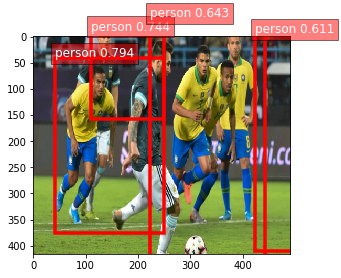

In [15]:
ax = viz.plot_bbox(mx.image.imresize(mx.image.imdecode(bimage), 492, 416), mx.nd.array(res['bbox']), mx.nd.array(res['score']), mx.nd.array(res['cid']), class_names=['person'])